<a href="https://colab.research.google.com/github/Lokesh1854/Short-Term-Load-Forecasting/blob/main/series_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import requests
from io import StringIO

# Define the Google Drive URL
# https://drive.google.com/file/d/1dZdseEOwt8afDB-qC_yxEOIwCjn9EzIv/view?usp=sharing
url = 'https://drive.google.com/uc?id=1dZdseEOwt8afDB-qC_yxEOIwCjn9EzIv&export=download'


# Fetch the content of the file
response = requests.get(url)

# Create a StringIO object to read the content as a file-like object
csv_content = StringIO(response.text)

# Read the CSV content using pd.read_csv()
df = pd.read_csv(csv_content)

In [ ]:
df.head()

,timestamp,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,PowerConsumption
0,2012-10-24 00:00:00,-3.040790,-1.740852,0.405477,1.179880,0.876442,0.504398,-0.698379,1.454913,11.464
1,2012-10-24 00:30:00,-3.034449,-1.735630,0.439827,1.177191,0.860263,0.533077,-0.675210,1.386368,10.475
2,2012-10-24 01:00:00,-3.028108,-1.730409,0.474176,1.174501,0.844084,0.561757,-0.652041,1.317824,10.003
3,2012-10-24 01:30:00,-3.010669,-1.704303,0.471834,1.142232,0.814760,0.559801,-0.644318,1.215007,9.748
4,2012-10-24 02:00:00,-2.993230,-1.678196,0.469492,1.109962,0.785436,0.557846,-0.636595,1.112190,9.480


In [ ]:
#sigmoid: 1/1+e^-x, takes value 0 to 1, most commonly used at output layer, for binary classification
#tanh: (e^x - e^-x)/(e^x + e^-x), takes values from -1 to 1, max of derivative if tanh is 1, while that if sigmoid is just 0.25, so model can be trained much faster, avg comes close to 0
#for very high or very low values of x, derivatives of sigmoid and tanh functions have very low values, called vanishing gradient problem
#ReLU (Rectified Linear Unit): max(0,x), piecewise linear, solves vanishing gradient problem
#leaky ReLu: max(0.01x,x)
#ELU: max(a(e^x -1),x)
#softmax: fi(x) = (e^ai)/summation over k (e^ak), used in output layer of multiclass classification

In [ ]:
#lesser the cost function, greater the accuracy
#cost function is the error repn
#loss is the error of just 1 observation, cost is the average of all those errors
#1. for regression problem: MAE, MSE
#2. for binary classification: logistic regression cost funcn (also called binary cross entropy)
#3. for multiclass classification: categorical cross entropy

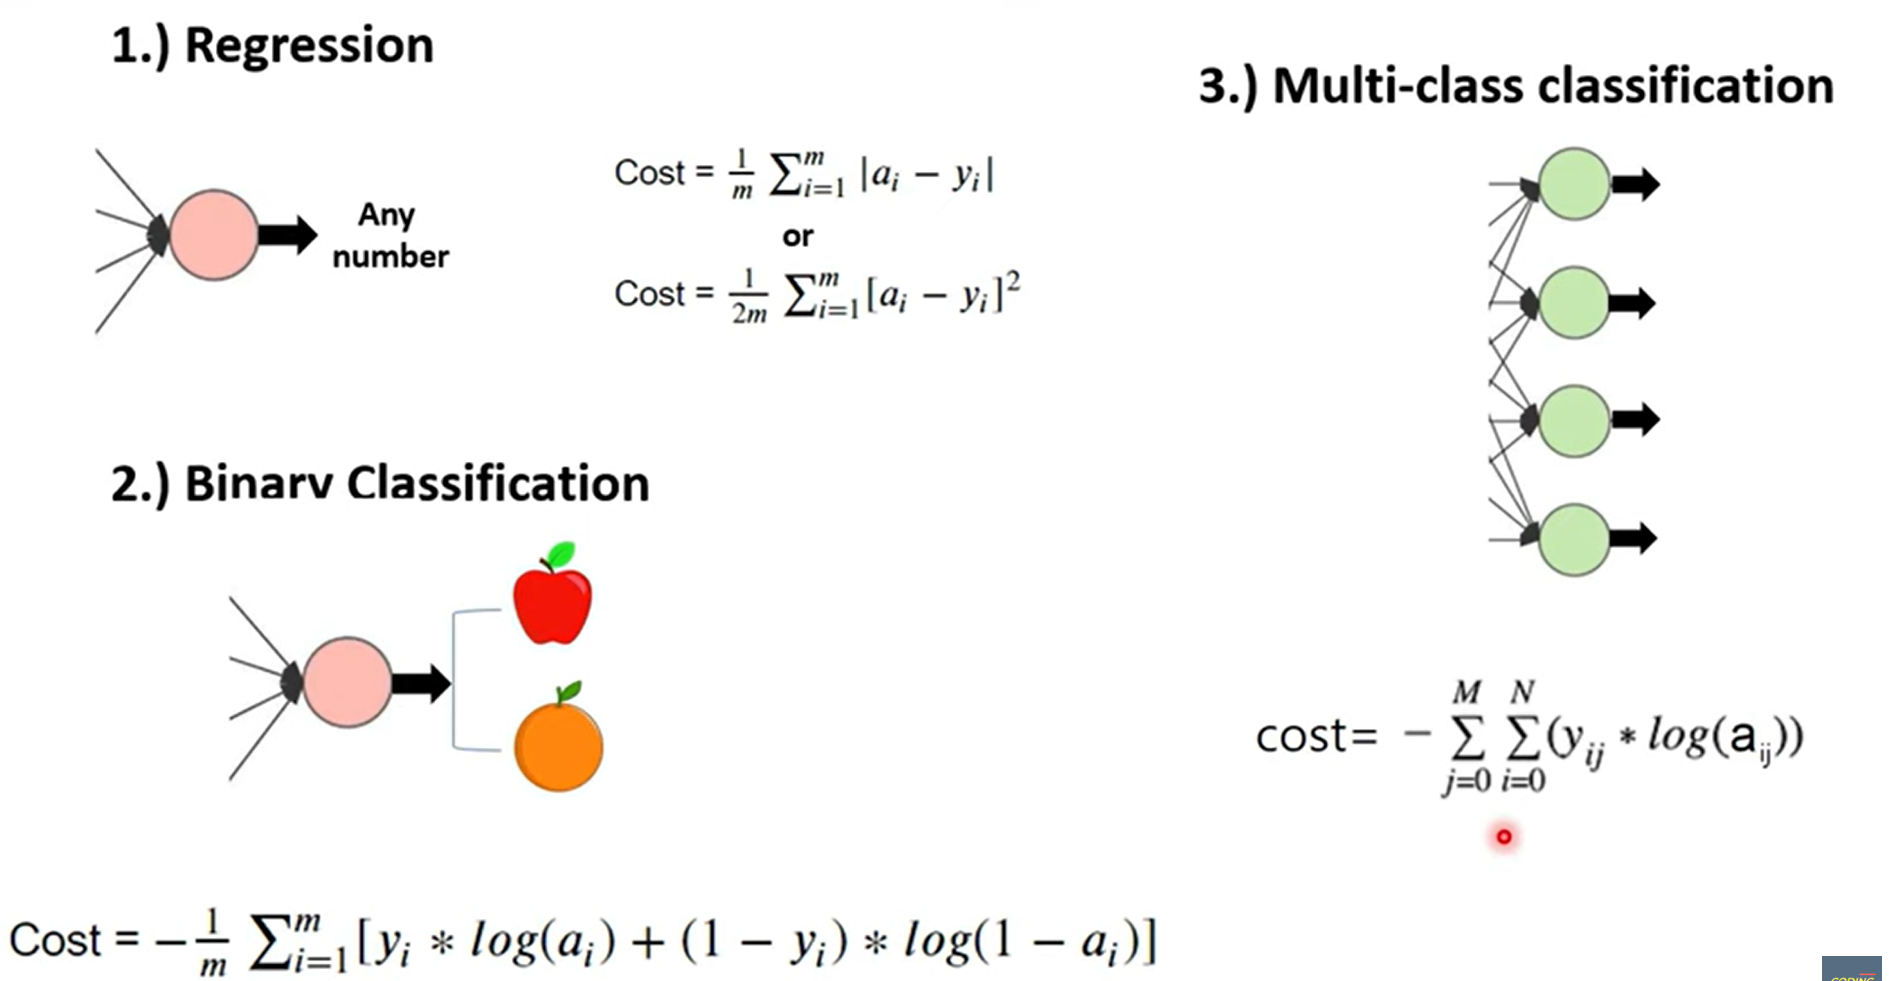

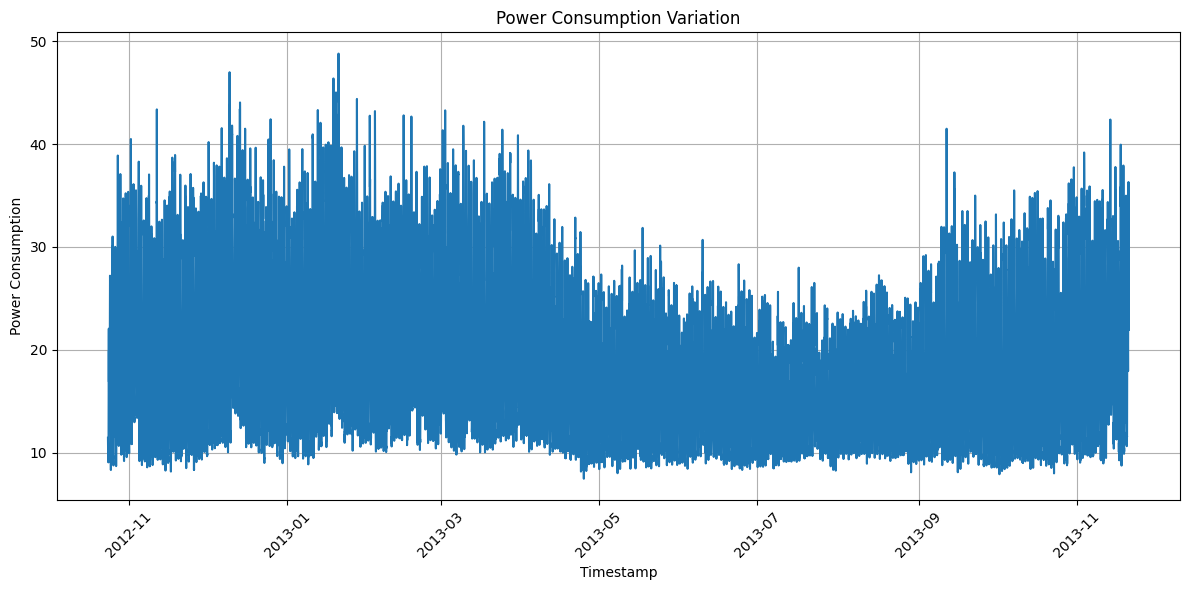

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt  # Import for additional plot customization

df["timestamp"] = pd.to_datetime(df["timestamp"])

# Set plot dimensions (adjust as needed)
plt.figure(figsize=(12, 6))

# Create the line plot with labels
sns.lineplot(x=df.timestamp, y=df.PowerConsumption, data=df)

# Customize labels and title (optional)
plt.xlabel("Timestamp")
plt.ylabel("Power Consumption")
plt.title("Power Consumption Variation")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)  # Add gridlines for better visualization (optional)
plt.tight_layout()  # Adjust spacing between elements for clarity (optional)
plt.show()


In [ ]:
df.shape

(18860, 10)

In [ ]:
def series_to_supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of output sequence
    :return: return two ndarrays-- input and output in a format suitable to feed to CNN
    """
    print(data.shape)
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    print(dim_0,dim_1)
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data.iloc[i:i + seq_len].values  # Convert DataFrame slice to numpy array
        y[i] = data.iloc[i + seq_len:i + seq_len + target_len]['PowerConsumption'].values  # Select 'PowerConsumption' column
    print("supervised data: shape of x: {}, shape of y: {}".format(x.shape, y.shape))
    return x, y

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    test_x_list = list()
    train_y_list = list()
    test_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        test_x_list.append(X[valid_index])
        test_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, test_x_list, test_y_list

In [ ]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, GlobalAveragePooling1D,DepthwiseConv1D
from keras import Sequential
from tensorflow.keras.layers import Activation

class CNN_1D(object):
    def __init__(self, output_size, drop_prob):
        self.output_size = output_size
        self.drop_prob = drop_prob
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()

        # Block 1
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', input_shape=(72, 9)))
        model.add(layers.Activation('relu'))
        model.add(Conv1D(filters=64, kernel_size=3, strides=2, padding='same'))
        model.add(layers.Activation('relu'))

        # # Block 2
        # model.add(Conv1D(filters=32, kernel_size=5, padding='same'))
        # model.add(layers.Activation('relu'))
        # model.add(Conv1D(filters=64, kernel_size=5, strides=2, padding='same'))
        # model.add(layers.Activation('relu'))

        # # Block 3
        # model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
        # model.add(layers.Activation('relu'))
        # model.add(Conv1D(filters=128, kernel_size=3, strides=2, padding='same'))
        # model.add(layers.Activation('relu'))

        # Global average pooling
        model.add(GlobalAveragePooling1D())

        # Dense layers
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(self.drop_prob))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.output_size))

        model.compile(loss='mape', optimizer='adam', metrics=['mse'])
        return model

In [ ]:
# from tensorflow.keras.callbacks import TensorBoard
# log_dir = f'/content/drive/MyDrive/tensorboard_logs/cnntry'
# tensorboard_callback = TensorBoard(log_dir=log_dir)

In [ ]:
#from keras.layers import Dense, LSTM, Flatten
from tensorflow.keras import optimizers
#from tensorflow.python.keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import LSTM
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D


seq_len=72
target_len=48

# Step 1: Prepare Data
X, Y = series_to_supervise(df[['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity', 'PowerConsumption']], seq_len, target_len)

# Step 2: Split Data
train_x_list, train_y_list, test_x_list, test_y_list = time_series_split(X, Y)
print("train x ", len(train_x_list),len(train_x_list[0]),len(train_x_list[0][0]))
for i in train_x_list:
  print(len(i))
# Step 3: Instantiate Model
output_size = target_len  # Forecasting for the next 24 hours
drop_prob = 0.2
# cnn_model = CNN_1D(output_size, drop_prob)

# Concatenate train data
train_x = np.concatenate(train_x_list, axis=0)
train_y = np.concatenate(train_y_list, axis=0)

# Concatenate test data
test_x = np.concatenate(test_x_list, axis=0)
test_y = np.concatenate(test_y_list, axis=0)

print(f"train x shape : {train_x.shape}")
# Reshaping
subsequences = 2
timesteps = 72 //subsequences
timesteps2 = 72
X_train_series_sub = train_x.reshape((train_x.shape[0], subsequences, timesteps, 9))
# X_valid_series_sub = test_x.reshape((test_x.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape,train_x.shape)
# print('Validation set shape', X_valid_series_sub.shape)

epochs = 25
batch = 256
lr = 0.0001
adam = optimizers.Adam(lr)

model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(timesteps2, 9))) # Define input shape here
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=6,strides=2, padding='same', activation='relu')))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn_lstm.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
#model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(LSTM(128, activation='tanh'))
model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(Dense(32))
model_cnn_lstm.add(Dense(16))
model_cnn_lstm.add(Dense(4))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

(18860, 9)
18741 9
supervised data: shape of x: (18741, 72, 9), shape of y: (18741, 48)
train x  5 3126 72
3126
6249
9372
12495
15618
train x shape : (46860, 72, 9)
Train set shape (46860, 2, 36, 9) (46860, 72, 9)


In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(train_x, train_y, validation_split=0.1, epochs=epochs)

Epoch 1/25
1318/1318 [==============================] - 39s 20ms/step - loss: 62.5917 - val_loss: 19.0635
Epoch 2/25
1318/1318 [==============================] - 13s 10ms/step - loss: 51.7975 - val_loss: 19.1783
Epoch 3/25
1318/1318 [==============================] - 12s 9ms/step - loss: 51.4414 - val_loss: 19.1052
Epoch 4/25
1318/1318 [==============================] - 12s 9ms/step - loss: 51.1307 - val_loss: 19.0950
Epoch 5/25
1318/1318 [==============================] - 12s 9ms/step - loss: 50.9049 - val_loss: 19.0852
Epoch 6/25
1318/1318 [==============================] - 12s 9ms/step - loss: 50.7734 - val_loss: 19.2118
Epoch 7/25
1318/1318 [==============================] - 12s 9ms/step - loss: 50.6668 - val_loss: 19.2242
Epoch 8/25
1318/1318 [==============================] - 13s 10ms/step - loss: 50.5947 - val_loss: 19.3343
Epoch 9/25
1318/1318 [==============================] - 12s 9ms/step - loss: 50.5442 - val_loss: 19.3295
Epoch 10/25
1318/1318 [=============================

In [ ]:
from sklearn.metrics import mean_absolute_error

# Making predictions
predictions_cnnlstm = model_cnn_lstm.predict(test_x)

# Calculating MAPE
mape = np.mean(np.abs((test_y - predictions_cnnlstm) / test_y)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

488/488 [==============================] - 2s 3ms/step
Mean Absolute Percentage Error (MAPE): 28.538980624432085
